# Predicting Survival probability of passengers aboard the Titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv("test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [3]:
train = pd.read_csv("train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Understanding the columns

- PassengerID - A column added by Kaggle to identify each row and make submissions easier
- Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
- Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
- Sex - The passenger's sex
- Age - The passenger's age in years
- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fare the passenger paid
- Cabin - The passenger's cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

# Machine Learning Model

- Since we are predicting two outcomes: surviving/ not surviving, the model is called classification
- Understanding the context is key for best model performance
- When watching the titanic movie, one can remember that children and women were given priority to access life-boats. Therefore the sex and age columns are key
- Furthermore, we can assume that higher-class cabins were getting as well priority access to life-boats. As a result, we will consider the class column as important too.

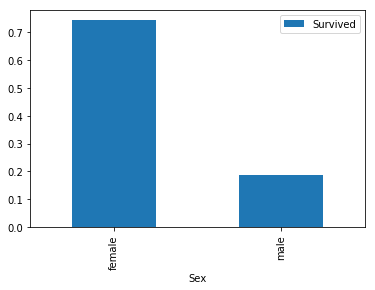

In [5]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

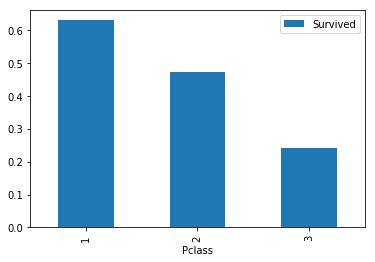

In [6]:
PClass_pivot = train.pivot_table(index="Pclass",values="Survived")
PClass_pivot.plot.bar()
plt.show()

In [7]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [8]:
train["Age"].isna().sum()

177

Let's create two histograms to compare visually those that survived vs those who died across different age ranges

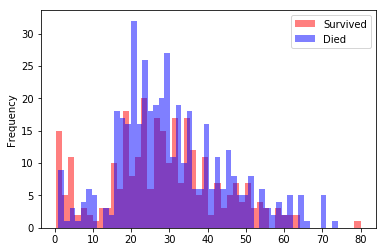

In [9]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The histogram doesn't show a clear cut, therefore we'll cluster Age values into categories;

- Missing, from -1 to 0
- Infant, from 0 to 5
- Child, from 5 to 12
- Teenager, from 12 to 18
- Young Adult, from 18 to 35
- Adult, from 35 to 60
- Senior, from 60 to 100


In [10]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

In [11]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

In [12]:
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

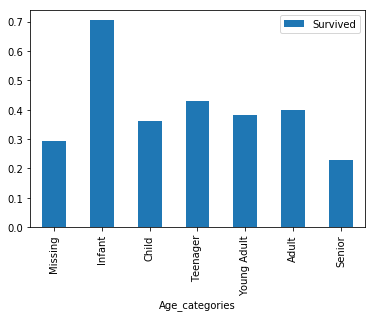

In [13]:
pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

So far we have identified 3 columns for predicting survival;
- Sex
- Pclass
- Age, the new created column Age_categories

Since we created a text label column (Age_categories) we'll create dummies to make it ML readable.
Additionally, we will have to create dummies for the Pclass column since it is currently  either 1,2 or 3 and the ML might think that the class 2 is twice more expensive than 1 for e.g. whilst there isn't such a relation

In [14]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [15]:
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

In [16]:
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

In [17]:
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

# Logistic Regression

We'll start with using the logistic regression as our first ML model for classification

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression()

In [20]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
lr.fit(train[columns], train['Survived'])

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Splitting our training data-set

Instead of having to submit our predictions directly to Kaggle, we would want to first make sure our model is having a good prediction score.
Therefore, it's best to split our training data in 2: 80%(train) and 20%(test)

The initial test data will be called 'holdhout' instead

In [21]:
holdout = test

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
all_X = train[columns]
all_y = train['Survived']

In [24]:
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size = 0.2, random_state = 0)

In [25]:
lr.fit(train_X, train_y)

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
predictions = lr.predict(test_X)

# Measuring accuracy

https://www.kaggle.com/c/titanic#evaluation

Kaggle uses 'the percentage of passengers correctly predicted' as the form of accuracy for binary classification


In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

Considering our small data-set an 81% score has a high-chance to mean over-fitting

# Cross Validation

To give a better results, we'll use cross validation that train and test the model on different splits of data and then averages accuracy scores

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = np.mean(scores)

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

In [31]:
print([scores, accuracy])

[array([0.8       , 0.81111111, 0.7752809 , 0.87640449, 0.80898876,
       0.78651685, 0.76404494, 0.76404494, 0.83146067, 0.80681818]), 0.8024670865963002]


Surprisingly we get a similar number of 80% of accuracy - let's now check the accuracy on supposedly unseen data (test data aka 'holdout)

In [32]:
holdout_predictions = lr.predict(holdout[columns])

# Submitting a file to Kaggle - 1

We'll respect the format provided https://www.kaggle.com/c/titanic#evaluation to submit our results

In [33]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

In [34]:
submission.to_csv("submission.csv",index=False)

# 0.76315 Accuracy

We got the result of 76.315% of accuracy - which landed us the 15,700+ position on the leaderboard.
This low score means there is still room for improvement;

- Improving the features we train our model on
- Improving the model itself


We'll start by improving our features we trained the model on

In [35]:
def process_age_2(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies_2(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [36]:
train = process_age_2(train)
holdout = process_age_2(holdout)

In [37]:
for column in ["Age_categories", "Pclass", "Sex"]:
    train = create_dummies_2(train, column)
    holdout = create_dummies_2(holdout, column)

Let's add relevant features;

- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fare the passenger paid
- Cabin - The passengers cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [38]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare        Cabin Embarked
count   891.000000  891.000000  891.000000          204      889
unique         NaN         NaN         NaN          147        3
top            NaN         NaN         NaN  C23 C25 C27        S
freq           NaN         NaN         NaN            4      644
mean      0.523008    0.381594   32.204208          NaN      NaN
std       1.102743    0.806057   49.693429          NaN      NaN
min       0.000000    0.000000    0.000000          NaN      NaN
50%       0.000000    0.000000   14.454200          NaN      NaN
max       8.000000    6.000000  512.329200          NaN      NaN


- Cabin has values for only 204 of the 891 rows
- SibSp, Parch and Fare have highly different ranges - therefore we'll have to rescale these and get values between 0 and 1

In [39]:
from sklearn.preprocessing import minmax_scale

In [40]:
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

In [41]:
features_columns = ["SibSp","Parch","Fare"]

In [42]:
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

In [43]:
train= create_dummies(train, "Embarked")
holdout= create_dummies(holdout, "Embarked")

In [44]:
for col in features_columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


How do we know if the features are relevant to our outcome? i.e. indicating survival

In [45]:
check_columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

In [46]:
len(check_columns)

18

In [47]:
lr_3 = LogisticRegression()
lr_3.fit(train[check_columns], train["Survived"])

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
coefficients = lr_3.coef_
coefficients

array([[-1.74325596e-01, -1.74325596e-01,  1.02101332e+00,
         1.02101332e+00,  2.09839345e-01,  2.09839345e-01,
        -9.26078943e-02, -9.26078943e-02, -2.40150330e-04,
        -2.40150330e-04, -2.70760188e-01, -2.70760188e-01,
        -5.16032427e-01, -5.16032427e-01,  5.61304392e-01,
         5.61304392e-01,  8.24624673e-02,  8.24624673e-02,
        -4.66880446e-01, -4.66880446e-01,  7.67714962e-01,
         7.67714962e-01, -5.90828549e-01, -5.90828549e-01,
         2.24132963e-01,  2.31238817e-01, -2.78485367e-01,
        -1.82644647e+00, -8.32835679e-01,  4.96589503e-01]])

In [49]:
len(train[check_columns].columns)

30

In [50]:
feature_importance = pd.Series(coefficients[0], index = train[check_columns].columns)

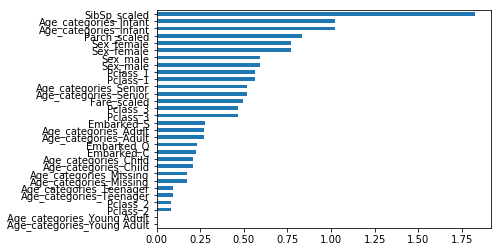

In [51]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

Let's select the 8 top scores features and train the model with it

In [52]:
interesting_features = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

In [53]:
all_X_2 = train[interesting_features]
all_y_2 = train["Survived"]

In [54]:
scores = cross_val_score(lr, all_X_2, all_y_2, cv = 10)

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

In [55]:
accuracy = scores.mean()
accuracy

0.8148019521053229

The score is slightly higher than the previously
Let's further feature engineer the model by using binning on the fare paid by passengers

In [56]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

In [57]:
cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

In [58]:
train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

In [59]:
train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

Furthermore, let's have a look at cabins

In [60]:
print(train.head()["Cabin"])

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object


In [61]:
print(train.head()["Cabin"].str[0])

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Cabin, dtype: object


And as well titles in names

In [62]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

In [63]:
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)


In [64]:
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

In [65]:
train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

In [66]:
holdout["Cabin_type"] = holdout["Cabin"].str[0]
31
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

In [67]:
for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

We now have 34 features - this might lead to collinearity (i.e. when more than 1 feature contains data that is similar)

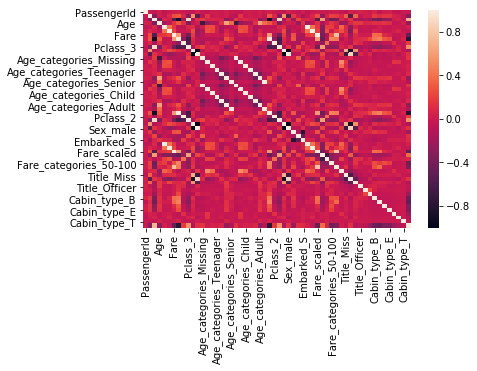

In [68]:
import seaborn as sns
correlations = train.corr()
sns.heatmap(correlations)
plt.show()

let's improve the plot

In [69]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

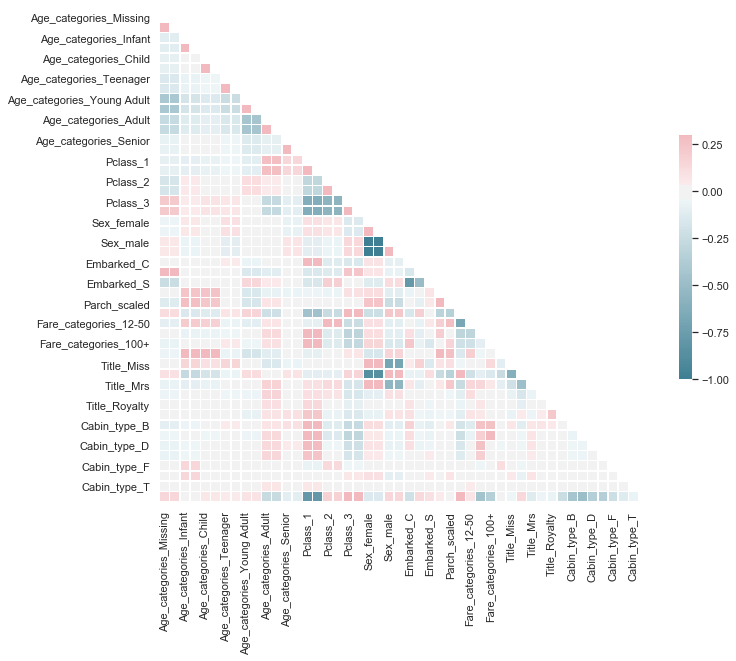

In [70]:
plot_correlation_heatmap(train[columns])

Checking the correlation we can find that there is a high correlation between titles and sex - obviously
As well, we'll remove some duplicate dummies;
- Pclass_2
- Age_categories_Teenager
- Fare_categories_12-50
- Title_Master
- Cabin_type_A

In [71]:
interesting_columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

In [72]:
from sklearn.feature_selection import RFECV

In [73]:
all_X_4 = train[interesting_columns]
all_y_4 = train["Survived"]

In [74]:
lr_4 = LogisticRegression()

In [75]:
selector = RFECV(lr_4, cv=10)

In [76]:
selector.fit(all_X_4, all_y_4)

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [77]:
optimised_columns = all_X_4.columns[selector.support_]

In [78]:
optimised_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

Our optimiser has returned four columns that apparently provide the highest impact on "Survived"
Let's use them to train a model using cross validation and check the score

In [79]:
all_X_5 = train[optimised_columns]
all_y_5 = train["Survived"]

In [80]:
lr_5 = LogisticRegression()

In [81]:
scores = cross_val_score(lr_5, all_X_5, all_y_5, cv=10)
accuracy = scores.mean()
accuracy

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Lo

0.8226549199863807

The model using the optimised features scores a 82% accuracy, a small improvement

# Model Selection

Now that we have worked on the features, let's improve the model itself

We'll start with a simple KNeighborsClassifier

In [82]:
from sklearn.neighbors import KNeighborsClassifier
knn_6 = KNeighborsClassifier(n_neighbors = 1)

In [83]:
scores_6 = cross_val_score(knn_6, all_X_5, all_y_5, cv= 10)

In [84]:
accuracy_knn = scores_6.mean()
accuracy_knn

0.7429142549086369

# hyperparameter optimisation.

We initiated the model with a k value of 1, so let's explore with more

In [85]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

In [86]:
knn_scores_7 = dict()

In [87]:
for k in range(1,50,2):
    knn_7 = KNeighborsClassifier(n_neighbors=k)

    scores_7 = cross_val_score(knn_7, all_X_5, all_y_5, cv=10)
    accuracy_knn_7 = scores_7.mean()
    knn_scores_7[k] = accuracy_knn_7

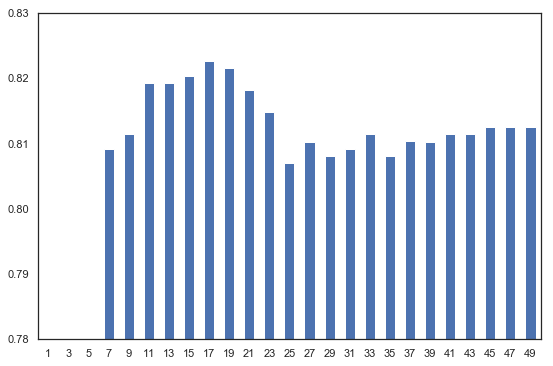

In [88]:
plot_dict(knn_scores_7)

A k value of 17 gives us our best score

Let's automate the Grid Search process

In [89]:
from sklearn.model_selection import GridSearchCV

In [91]:
hyperparameters = {
    "n_neighbors": range(1, 20, 2),
    "weights": ["distance", "uniform"],
    "algorithm": ["brute"],
    "p": [1,2]
}

In [92]:
knn_7 = KNeighborsClassifier()

In [93]:
grid = GridSearchCV(knn_7, param_grid = hyperparameters, cv=10)
grid.fit(all_X_5, all_y_5)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(1, 20, 2), 'weights': ['distance', 'uniform'], 'algorithm': ['brute'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
best_params = grid.best_params_
best_score = grid.best_score_

In [95]:
print([best_params, best_score])

[{'algorithm': 'brute', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}, 0.8181818181818182]


We score a 81.8% accuracy, which is an improvement!

Let's retrieve a trained model with the best performing hyperparameters

In [97]:
best_knn = grid.best_estimator_
best_knn

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=1,
           weights='distance')

# Random Forest

Despite good results with the Kneighbor classifier, our model might be overfitting because we are using all columns
Therefore we'll work with the Random Forest algorithm, which is best to avoid overfitting

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
clf_8 = RandomForestClassifier(random_state= 1)

In [100]:
scores_8 = cross_val_score(clf_8, all_X_5, all_y_5, cv = 10)

C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Gabriel_pirastru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

In [102]:
accuracy_rf_8 = scores_8.mean()
accuracy_rf_8

0.8193215866530472

We get a pretty good result with 81.9% accuracy
Let's try to squeeze more accuracy with GridSearchCV

In [104]:
hyperparameters_8 = {"criterion": ["entropy", "gini"],
                   "max_depth": [5,10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1,5],
                   "min_samples_split": [3,5],
                   "n_estimators": [6,9]
                  }

In [105]:
grid_8 = GridSearchCV(clf_8, param_grid = hyperparameters_8, cv= 10)

In [106]:
grid_8.fit(all_X_5, all_y_5)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [5, 10], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [1, 5], 'min_samples_split': [3, 5], 'n_estimators': [6, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [109]:
best_params_8 = grid_8.best_params_
best_score_8 = grid_8.best_score_

In [110]:
print([best_params_8, best_score_8])

[{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}, 0.8181818181818182]


Despite our gridsearch, the model performed a little less well than expected

In [112]:
best_rf_8 = grid_8.best_estimator_
best_rf_8

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

# Conclusion

- The Random forest performs best and surprisingly Grid didn't provide the best accuracy
- Potentially we could further look into features and parameter optimisation to get a better accuracy
- Other models could be introduced, though RF is deemed best for such tasks
- Therefore we'll close this project for now